In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from ekonlpy.tag import Mecab
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
intent_df = pd.read_csv("./data/intent_df.csv")

In [4]:
intent_df.head()

,question,intent
0,디딤 차트,가격
1,포시에스 그래프 보여줘,가격
2,메카로 사업 개요가 궁금해,사업개요
3,조광페인트 종가 보여줘,가격
4,음식료품랑 연관된 주식 모 있어?,키워드


## 레이블 전처리 및 padding

In [5]:
idx_encoding = preprocessing.LabelEncoder()
label_data = idx_encoding.fit_transform(intent_df["intent"].to_list())

In [6]:
label_data

array([0, 0, 1, ..., 2, 2, 1])

In [7]:
label_idx = dict(zip(list(idx_encoding.transform(list(idx_encoding.classes_)) ), idx_encoding.classes_))

In [8]:
mecab = Mecab()
data_X = []
for sentence in intent_df["question"]:
    temp_X = mecab.morphs(sentence)
    data_X.append(temp_X)

In [9]:
data_X[:10]

[['디딤', '차트'],
 ['포시에스', '그래프', '보여줘'],
 ['메카로', '사업', '개요', '가', '궁금', '해'],
 ['조광페인트', '종가', '보여줘'],
 ['음식료품', '랑', '연관', '된', '주식', '모', '있', '어', '?'],
 ['동양에스텍', '시가', '얼마', '냐'],
 ['시노펙스', '가격', '이', '어떻게', '돼', '?'],
 ['엔에이치스팩19호', '사업', '개요', '볼래'],
 ['경보제약', '그래프', '띄워줘'],
 ['세보엠이씨', '와', '유사', '종목', '은', '뭐', '가', '있', '어', '?']]

문장의 최대 길이:  13
문장의 평균 길이:  5.0927969424837904


[Text(0.5, 0, 'length of sentence')]

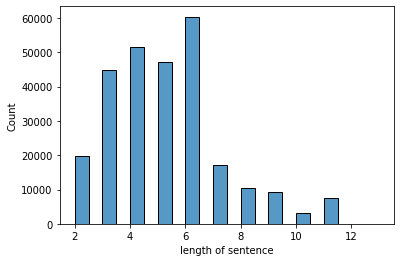

In [10]:
print("문장의 최대 길이: ", max(len(sent) for sent in data_X))
print("문장의 평균 길이: ", sum(map(len, data_X)) / len(data_X))
max_len = max(len(sent) for sent in data_X)

sns.histplot([len(sent) for sent in data_X], binwidth= 0.5).set(xlabel = "length of sentence")

In [11]:
intent_tokenizer = Tokenizer()
intent_tokenizer.fit_on_texts(data_X)
X_data = intent_tokenizer.texts_to_sequences(data_X)
X_data[:10]

[[86, 17],
 [87, 18, 10],
 [88, 6, 7, 12, 19, 4],
 [89, 46, 10],
 [2751, 5, 41, 39, 9, 32, 24, 13, 1],
 [90, 38, 27, 53],
 [91, 14, 11, 21, 22, 1],
 [92, 6, 7, 54],
 [93, 18, 47],
 [94, 16, 28, 25, 26, 35, 12, 24, 13, 1]]

In [12]:
X_data = pad_sequences(X_data, maxlen = max_len)
X_data[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          86,   17],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   87,
          18,   10],
       [   0,    0,    0,    0,    0,    0,    0,   88,    6,    7,   12,
          19,    4],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   89,
          46,   10],
       [   0,    0,    0,    0, 2751,    5,   41,   39,    9,   32,   24,
          13,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   90,   38,
          27,   53],
       [   0,    0,    0,    0,    0,    0,    0,   91,   14,   11,   21,
          22,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   92,    6,
           7,   54],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   93,
          18,   47],
       [   0,    0,    0,   94,   16,   28,   25,   26,   35,   12,   24,
          13,    1]], dtype=int32)

# 학습데이터, 테스트 데이터 분리

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, label_data, test_size = 0.2, random_state = 42)

In [14]:
len(X_train)

217274

In [15]:
intent_label_size = len(label_idx)

y_train = to_categorical(y_train, num_classes= intent_label_size)
y_test = to_categorical(y_test, num_classes= intent_label_size)

y_train

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [16]:
vocab_size = len(intent_tokenizer.word_index) + 1
vocab_size

3224

## 의도 분류기 학습

In [17]:
import pickle as pickle
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM
from tensorflow.keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(128))
model.add(Dense(intent_label_size, activation = "softmax"))

In [19]:
earlystop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 4)
checkpoint = ModelCheckpoint("./model/best_intent_model.h5", monitor = "val_acc", mode = "max", verbose = 1, save_best_only = True)

In [20]:
model.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["acc"])
history = model.fit(X_train, y_train, epochs = 5, callbacks = [earlystop, checkpoint], batch_size = 32, validation_split= 0.1)

Epoch 1/5
6108/6111 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9968
Epoch 00001: val_acc improved from -inf to 1.00000, saving model to ./model/best_intent_model.h5
6111/6111 [==============================] - 70s 11ms/step - loss: 0.0084 - acc: 0.9968 - val_loss: 2.9777e-05 - val_acc: 1.0000
Epoch 2/5
6111/6111 [==============================] - ETA: 0s - loss: 5.7363e-06 - acc: 1.0000
Epoch 00002: val_acc did not improve from 1.00000
6111/6111 [==============================] - 80s 13ms/step - loss: 5.7363e-06 - acc: 1.0000 - val_loss: 2.1723e-07 - val_acc: 1.0000
Epoch 3/5
6109/6111 [============================>.] - ETA: 0s - loss: 1.1717e-07 - acc: 1.0000
Epoch 00003: val_acc did not improve from 1.00000
6111/6111 [==============================] - 84s 14ms/step - loss: 1.1713e-07 - acc: 1.0000 - val_loss: 1.5713e-08 - val_acc: 1.0000
Epoch 4/5
6111/6111 [==============================] - ETA: 0s - loss: 2.8829e-09 - acc: 1.0000
Epoch 00004: val_acc did not

In [21]:
model = load_model("./model/best_intent_model.h5")

print("test data accuracy: {0:.4f}".format(model.evaluate(X_test, y_test)[1]))

1698/1698 [==============================] - 18s 11ms/step - loss: 3.1349e-05 - acc: 1.0000
test data accuracy: 1.0000


In [22]:
with open('./tokenizer/intent_tokenizer.pickle', 'wb') as handle:
    pickle.dump(intent_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('./tokenizer/intent_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [24]:
def predict(test_sentence):
    with open('./tokenizer/intent_tokenizer.pickle', 'rb') as handle:
        loaded_tokenizer = pickle.load(handle)
    
    test_sentence = mecab.morphs(test_sentence)
    test_sentence_encoding = loaded_tokenizer.texts_to_sequences([test_sentence])
    test_sentence_padded = pad_sequences(test_sentence_encoding, maxlen = max_len)
    y_predicted = model.predict(test_sentence_padded)
    y_predicted = np.argmax(y_predicted, axis = -1)
    
    return label_idx[y_predicted[0]]

In [40]:
predict("삼전 가격 알려줘")

'가격'

In [44]:
print("1. '삼성전자랑 유사한 종목 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: {0}".format( predict('삼성전자랑 유사한 종목 알려줘')))
print("2. '유사종목 삼성전자' | 실제 의도: 유사기업 | 모델 예측 의도: {0}".format(predict('유사종목 삼성전자')))
print("3. '삼전이랑 유사한 주식 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: {0}".format(predict('삼전이랑 유사한 주식 알려줘')))
print("4. '삼전이랑 비슷한 주식 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: {0}".format(predict('삼전이랑 비슷한 주식 알려줘')))
print("5. '삼전이랑 유사한 거 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: {0}".format(predict('삼전이랑 유사한 거 알려줘')))
print("6. '반도체 관련 기업 알려줘' | 실제 의도: 키워드 | 모델 예측 의도: {0}".format(predict('반도체 관련 기업 알려줘')))
print("7. '키워드 반도체' | 실제 의도: 키워드 | 모델 예측 의도: {0}".format(predict('키워드 반도체')))
print("8. '삼성전자 분석' | 실제 의도: 사업개요 | 모델 예측 의도: {0}".format(predict('삼성전자 분석')))
print("9. '삼성전자 분석해봐라' | 실제 의도: 사업개요 | 모델 예측 의도: {0}".format(predict('삼성전자 분석해봐라')))
print("10. '삼성전자 요약' | 실제 의도: 사업개요 | 모델 예측 의도: {0}".format(predict('삼성전자 요약')))
print("11. '치킨 관련주 알려줘' | 실제 의도: 키워드 | 모델 예측 의도: {0}".format(predict('치킨 테마주 알려줘')))
print("12. 'GS리테일 개요' | 실제 의도: 사업개요 | 모델 예측 의도: {0}".format(predict('GS리테일 개요')))
print("13. 'GS리테일 가격 알려줘' | 실제 의도: 가격 | 모델 예측 의도: {0}".format(predict('GS리테일 가격 알려줘')))
print("14. 'GS리테일 종가가 궁금해' | 실제 의도: 가격 | 모델 예측 의도: {0}".format(predict('GS리테일 종가가 궁금해'))) 
print("15. 'GS리테일 변화율이 너무 너무 궁금해' | 실제 의도: 가격 | 모델 예측 의도: {0}".format(predict('GS리테일 변화율이 너무 너무 궁금해')))


1. '삼성전자랑 유사한 종목 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: 유사기업
2. '유사종목 삼성전자' | 실제 의도: 유사기업 | 모델 예측 의도: 유사기업
3. '삼전이랑 유사한 주식 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: 유사기업
4. '삼전이랑 비슷한 주식 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: 유사기업
5. '삼전이랑 유사한 거 알려줘' | 실제 의도: 유사기업 | 모델 예측 의도: 유사기업
6. '반도체 관련 기업 알려줘' | 실제 의도: 키워드 | 모델 예측 의도: 키워드
7. '키워드 반도체' | 실제 의도: 키워드 | 모델 예측 의도: 키워드
8. '삼성전자 분석' | 실제 의도: 사업개요 | 모델 예측 의도: 사업개요
9. '삼성전자 분석해봐라' | 실제 의도: 사업개요 | 모델 예측 의도: 사업개요
10. '삼성전자 요약' | 실제 의도: 사업개요 | 모델 예측 의도: 사업개요
11. '치킨 관련주 알려줘' | 실제 의도: 키워드 | 모델 예측 의도: 키워드
12. 'GS리테일 개요' | 실제 의도: 사업개요 | 모델 예측 의도: 사업개요
13. 'GS리테일 가격 알려줘' | 실제 의도: 가격 | 모델 예측 의도: 가격
14. 'GS리테일 종가가 궁금해' | 실제 의도: 가격 | 모델 예측 의도: 가격
15. 'GS리테일 변화율이 너무 너무 궁금해' | 실제 의도: 가격 | 모델 예측 의도: 가격
